 # Project Overview

This capstone project implements a data-driven system to optimize inventory management. It replaces static, rule-based reordering policies with a dynamic, predictive engine that forecasts future demand and calculates the optimal Reorder Point (ROP) and Reorder Quantity (ROQ) for each product.

The goal is to minimize total inventory costs by balancing the reduction of costly stockouts (lost sales) against the minimization of expensive holding costs (storage, capital tied up).

# 1. Import Libraries and Loading Data

In [2]:
# Install Statsmodels
#! pip install statsmodels

In [3]:
# Install Prophet 
#! pip install prophet

In [4]:
#! pip install tensorflow

In [5]:
# Install pmdarima for Auto ARIMA (run once)
#! pip install pmdarima


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima

import time
import warnings
warnings.filterwarnings("ignore")

C:\Users\USER\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
data = pd.read_csv('retail_store_inventory.csv')
data.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [8]:
#check the columns and data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

- No missing values in my data

In [9]:
data.columns

Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality'],
      dtype='object')

In [10]:
data.shape

(73100, 15)

# 2. EDA

In [11]:
# How many unique stores and products do we have?
num_stores = data['Store ID'].nunique()
num_products = data['Product ID'].nunique()
print(f"Number of unique stores: {num_stores}")
print(f"Number of unique products: {num_products}")

Number of unique stores: 5
Number of unique products: 20


In [12]:
# Convert 'Date' to datetime and create 'SKU_Compound_ID'
data['Date'] = pd.to_datetime(data['Date'])
data['SKU_Compound_ID'] = data['Store ID'] + '_'+ data['Product ID']

In [13]:
data.sort_values(by = ['SKU_Compound_ID', 'Date'], inplace=True)

In [14]:
# Data Quality Check
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")
print(f"Number of unique SKUs: {data['SKU_Compound_ID'].nunique()}")

Date range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00
Number of unique SKUs: 100


In [15]:
# Total Units sold 
print(f"• Total units sold: {data['Units Sold'].sum():,}")


• Total units sold: 9,975,582


Category and Regional Analysis

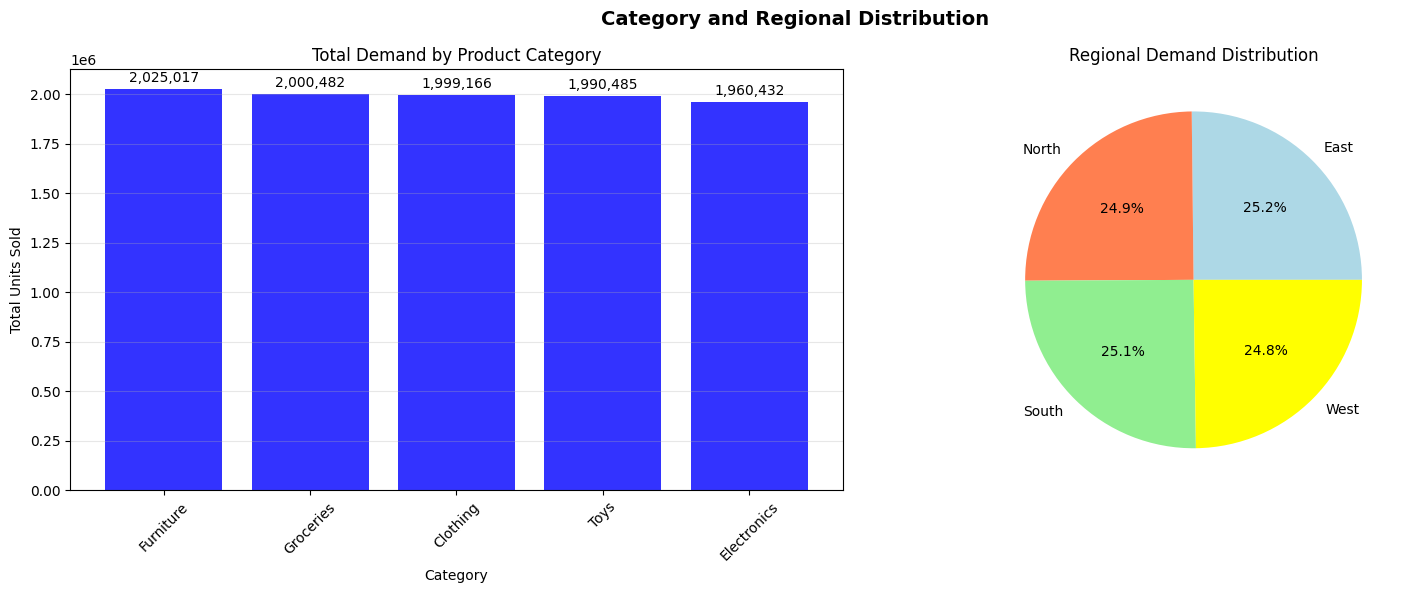

In [16]:
# Are the categories and regions equally distributed
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Category and Regional Distribution', fontsize=14, fontweight='bold')

# Category-wise demand distribution
category_demand = data.groupby('Category')['Units Sold'].sum().sort_values(ascending=False)
bars = axes[0].bar(category_demand.index, category_demand.values, color='blue', alpha=0.8)
axes[0].set_title('Total Demand by Product Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Total Units Sold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, category_demand.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
                f'{value:,.0f}', ha='center', va='bottom', fontsize=10)

# Regional demand distribution
regional_demand = data.groupby('Region')['Units Sold'].sum()
colors = ['lightblue', 'coral', 'lightgreen', 'yellow']
wedges, texts, autotexts = axes[1].pie(regional_demand.values, labels=regional_demand.index, 
                                      autopct='%1.1f%%', colors=colors[:len(regional_demand)])
axes[1].set_title('Regional Demand Distribution')

plt.tight_layout()
plt.show()

INSIGHTS

The categories are remarkably balanced - all within about 65,000 units of each other, suggesting a well-diversified product mix!


The regional split is very evenly balanced:
- There is a near-perfect 25% split across all regions indicates excellent geographic distribution of demand.
- There is excellent market penetration and distribution strategy.

The data shows a very mature, well-balanced retail operation with consistent demand across both product categories and geographic regions.

**Price Sensitivity Analysis - Does Price affect Demand?**

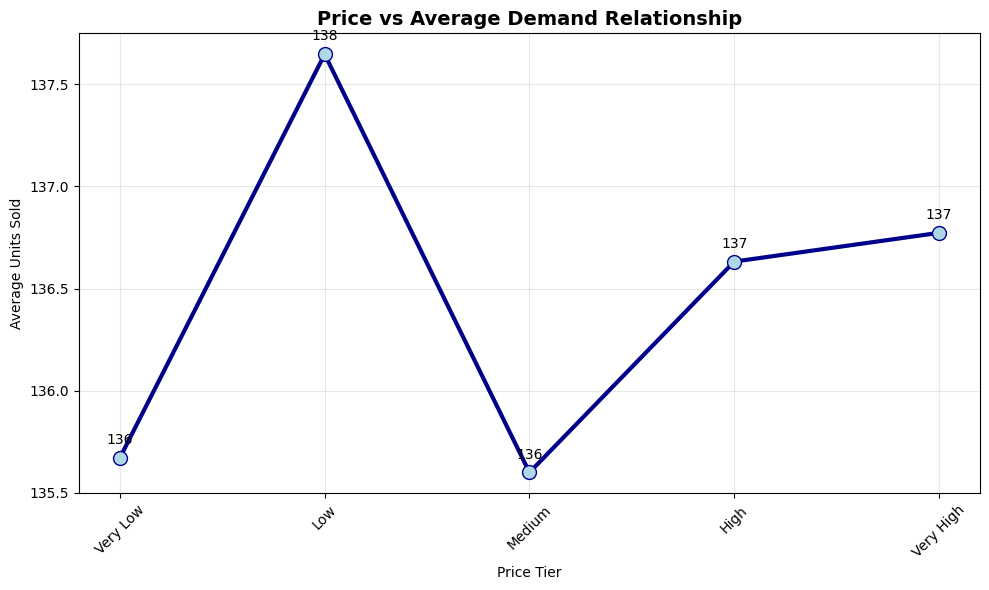

np.float64(0.8116756449759092)

In [17]:
# Create price bins for analysis
price_bins = pd.qcut(data['Price'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
price_demand = data.groupby(price_bins)['Units Sold'].mean()

# Visualize price vs demand relationship
plt.figure(figsize=(10, 6))
plt.plot(price_demand.index, price_demand.values, marker='o', linewidth=3, 
         markersize=10, color='darkblue', markerfacecolor='lightblue')
plt.title('Price vs Average Demand Relationship', fontsize=14, fontweight='bold')
plt.xlabel('Price Tier')
plt.ylabel('Average Units Sold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add value annotations
for i, (price_tier, avg_demand) in enumerate(price_demand.items()):
    plt.annotate(f'{avg_demand:.0f}', (i, avg_demand), 
                textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

# Calculate price elasticity
price_elasticity = (price_demand.iloc[-1] - price_demand.iloc[0]) / price_demand.iloc[0] * 100
price_elasticity

INSIGHTS 

1. Low Price Sensitivity: The demand barely changes across different price tiers (only 0.8% variation), indicating customers are not very price-sensitive. 

2. Optimal Pricing Strategy: The "Low" price tier shows the highest demand (138 units), suggesting there's a sweet spot in the lower-medium price range.

3. Business Implications are:
- You have pricing power and can potentially increase margins without significantly losing demand
- Focus on value proposition rather than aggressive price competition


**Discount Impact Analysis - Does Discount affect demand?**

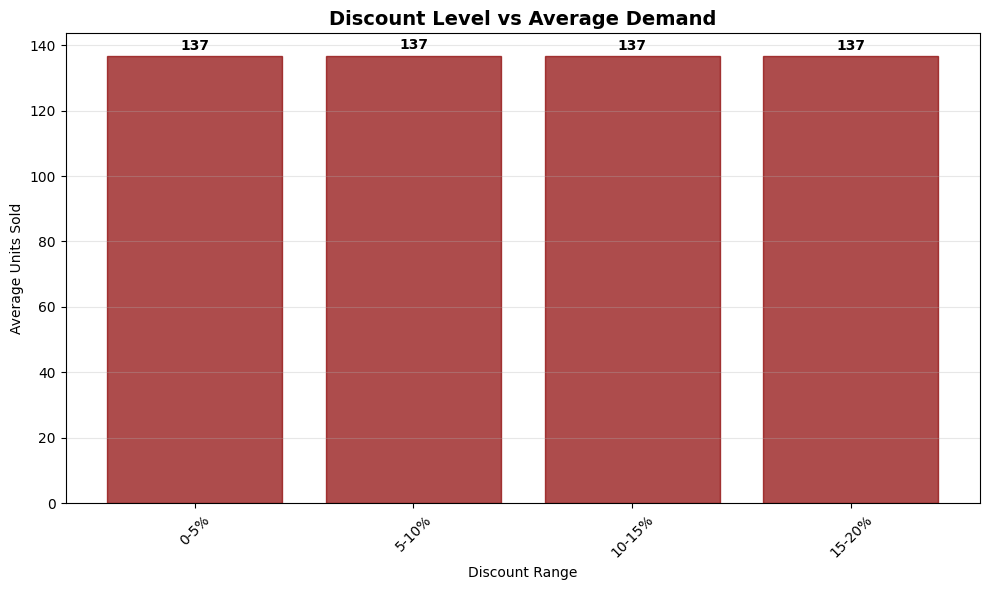

In [18]:
# This analysis will help us see how promotional discounts perform compared to base pricing

# Create discount bins
discount_bins = pd.cut(data['Discount'], bins=[0, 5, 10, 15, 20, 100], 
                      labels=['0-5%', '5-10%', '10-15%', '15-20%', '20%+'])
discount_demand = data.groupby(discount_bins)['Units Sold'].mean()

# Visualize discount impact
plt.figure(figsize=(10, 6))
bars = plt.bar(discount_demand.index, discount_demand.values, 
               color='darkred', alpha=0.7, edgecolor='darkred')
plt.title('Discount Level vs Average Demand', fontsize=14, fontweight='bold')
plt.xlabel('Discount Range')
plt.ylabel('Average Units Sold')
plt.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, discount_demand.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

INSIGHTS

1. There is Zero Discount Impact: Discounts have virtually no effect on demand as they all result in 137 units average demand.
2. Strategic Implications:
- Cost Savings Opportunity: You're giving away margin unnecessarily with deep discounts, withou gaining sales.
- Customer Behavior: Customers aren't price-sensitive to discounts either.

**Holiday/Promotion Impact Analysis**

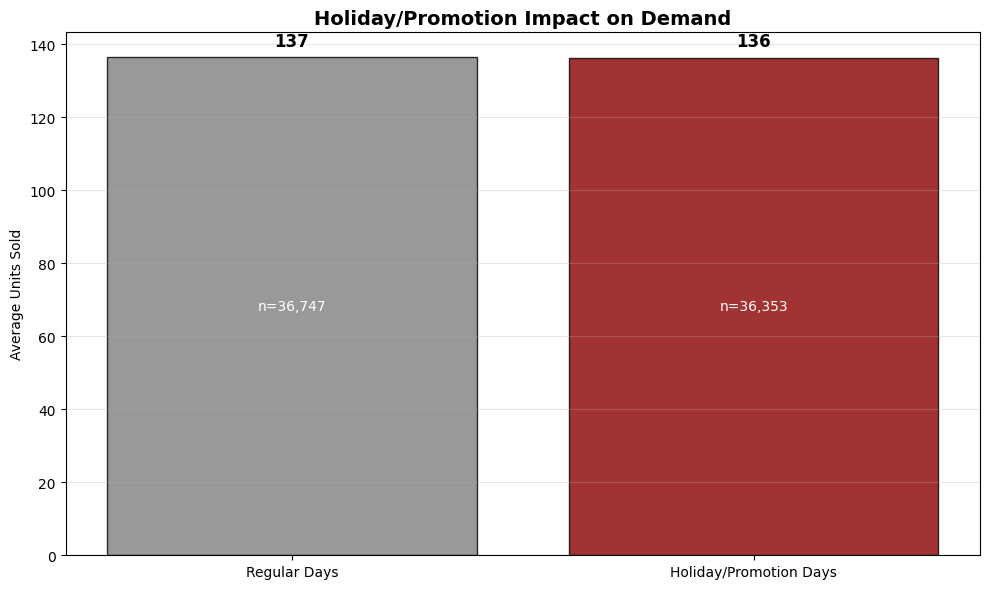

In [19]:
# This helps show us how seasonal factors perform compared to these pricing strategies

# Analyze holiday/promotion impact
holiday_impact = data.groupby('Holiday/Promotion')['Units Sold'].agg(['mean', 'count', 'std'])

# Visualize holiday impact
plt.figure(figsize=(10, 6))
x_labels = ['Regular Days', 'Holiday/Promotion Days']
bars = plt.bar(x_labels, holiday_impact['mean'], 
               color=['gray', 'darkred'], alpha=0.8, edgecolor='black')
plt.title('Holiday/Promotion Impact on Demand', fontsize=14, fontweight='bold')
plt.ylabel('Average Units Sold')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels and count info
for i, (bar, mean_val, count) in enumerate(zip(bars, holiday_impact['mean'], holiday_impact['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{mean_val:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
            f'n={count:,}', ha='center', va='center', fontsize=10, color='white')

plt.tight_layout()
plt.show()

INSIGHTS
1. There is over saturation since nearly 50% of days are either holidays or promotions.
2. The low statistical significance means that there is no meaningful difference.
3. All in all; Over-promotion has desensitized customers; holidays don't drive incremental sales

**Weaather Condition Impact Analysis**

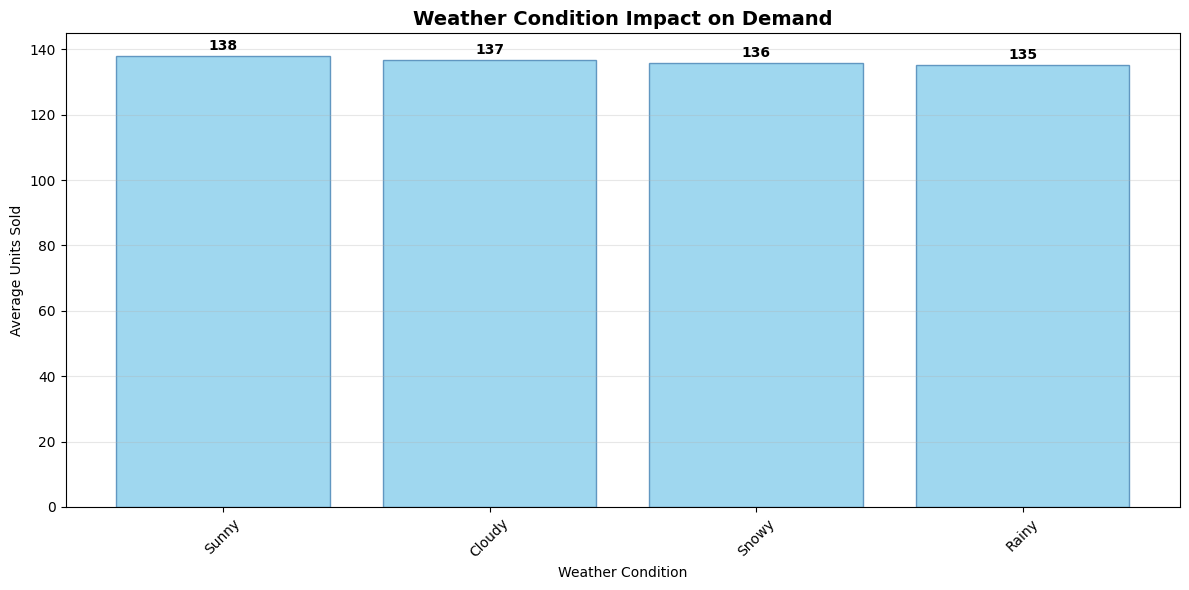

In [20]:
# Analyze weather impact on demand
weather_impact = data.groupby('Weather Condition')['Units Sold'].agg(['mean', 'count', 'std'])
weather_demand = weather_impact['mean'].sort_values(ascending=False)

# Visualize weather impact
plt.figure(figsize=(12, 6))
bars = plt.bar(weather_demand.index, weather_demand.values, 
               color='skyblue', alpha=0.8, edgecolor='steelblue')
plt.title('Weather Condition Impact on Demand', fontsize=14, fontweight='bold')
plt.xlabel('Weather Condition')
plt.ylabel('Average Units Sold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, weather_demand.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


INSIGHTS 

- Low weather sensitivity.
- Retail is likely indoor/online where weather doesn't affect shopping behavior.

Numeric columns found: ['Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion', 'Competitor Pricing']


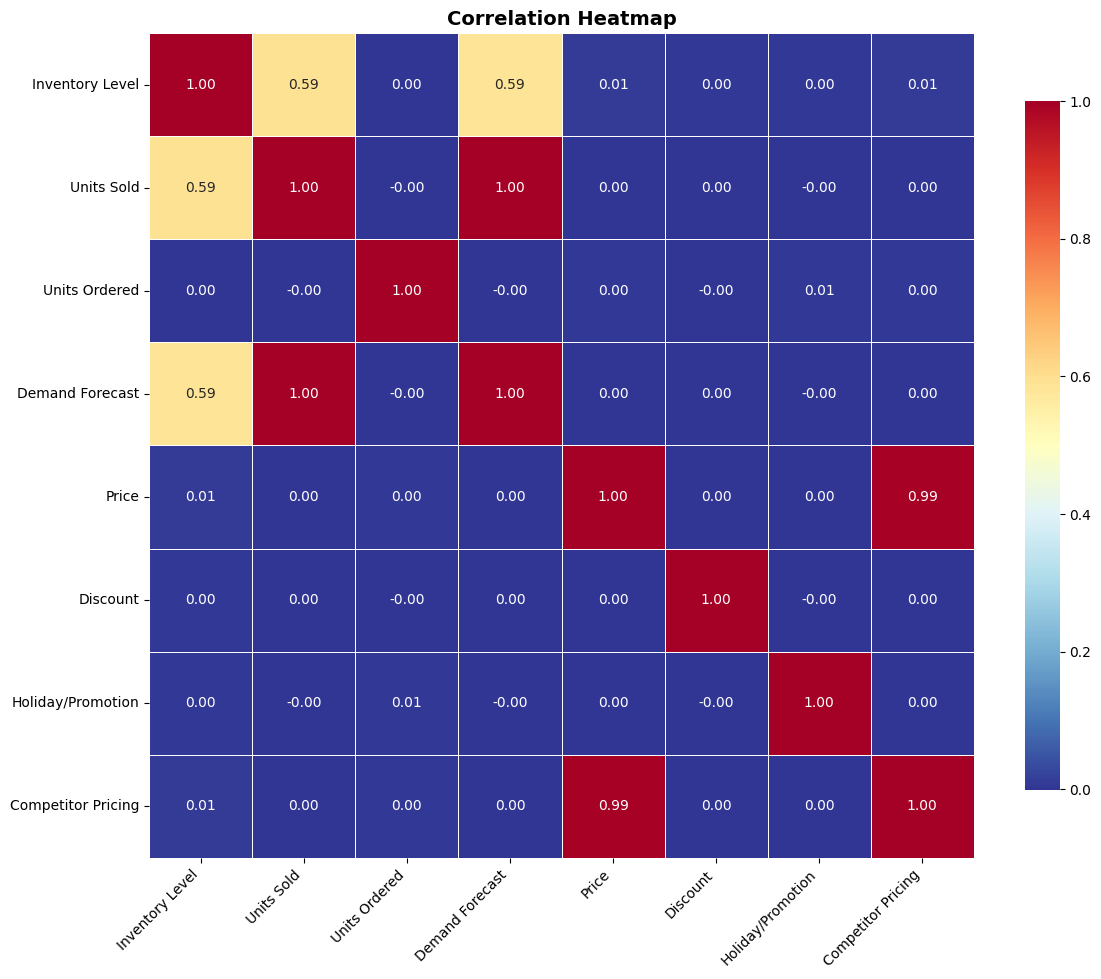

In [21]:
# Correlation Analysis - Numeric Columns Only
numeric_columns = data.select_dtypes(include=[np.number]).columns
print(f"Numeric columns found: {list(numeric_columns)}")

# Calculate correlations for numeric data only
correlations = data[numeric_columns].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
# mask = np.triu(np.ones_like(correlations, dtype=bool))  # Show only lower triangle
sns.heatmap(correlations, annot=True, cmap='RdYlBu_r', fmt=".2f", 
            linewidths=0.5, cbar_kws={'shrink': 0.8}, square=True)
plt.title('Correlation Heatmap', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

INSIGHTS

- Demand is clearly affected by external factors like competitive pricing, customer behaviour.

# Seasonality & Trend Decomposition Analysis

   Total days analyzed: 731


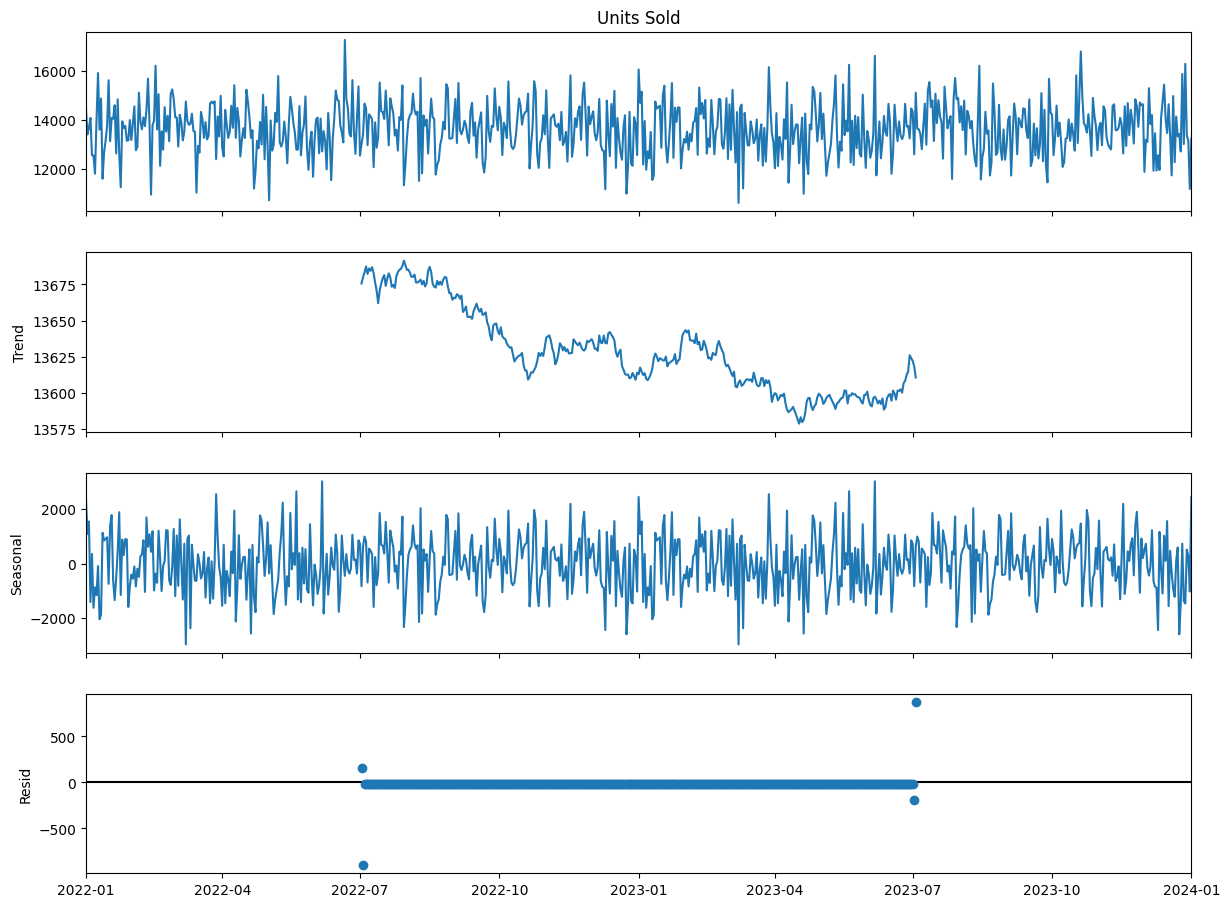

In [22]:
# Prepare daily demand data for time series analysis
daily_demand = data.groupby('Date')['Units Sold'].sum().reset_index()
daily_sales = daily_demand.set_index('Date')['Units Sold']

print(f"   Total days analyzed: {len(daily_sales)}")
#print(f"   Date range: {daily_sales.index.min()} to {daily_sales.index.max()}")

# Decompose the time series into components
decomposition = seasonal_decompose(daily_sales, model='additive', period=365)
fig = decomposition.plot()
fig.set_size_inches(14, 10) 
plt.show()

Analyze Day of Week Patterns

Which days of the week have the highest and lowest sales?

In [23]:
# Calculate average sales by day of week
data['day_name'] = data['Date'].dt.day_name()
avg_by_day = data.groupby('day_name')['Units Sold'].mean()

# Reorder to start from Monday
days_ordered = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_by_day = avg_by_day.reindex(days_ordered)

# Display results
print("Average Sales by Day of Week:")
for day, sales in avg_by_day.items():
    print(f"   {day:10s}: {sales:6.1f} units")
print()

Average Sales by Day of Week:
   Monday    :  135.1 units
   Tuesday   :  137.3 units
   Wednesday :  136.6 units
   Thursday  :  137.3 units
   Friday    :  136.9 units
   Saturday  :  135.3 units
   Sunday    :  136.8 units



Analyze Monthly Patterns

Which months have the highest and lowest sales?

In [24]:
# Calculate average sales by month
data['month_name'] = data['Date'].dt.month_name()
avg_by_month = data.groupby('month_name')['Units Sold'].mean()

# Reorder to start from January
months_ordered = ['January', 'February', 'March', 'April', 'May', 'June',
                  'July', 'August', 'September', 'October', 'November', 'December']
avg_by_month = avg_by_month.reindex(months_ordered)

# Display results
print("Average Sales by Month:")
for month, sales in avg_by_month.items():
    print(f"   {month:10s}: {sales:6.1f} units")
print()

Average Sales by Month:
   January   :  136.0 units
   February  :  138.6 units
   March     :  135.9 units
   April     :  134.7 units
   May       :  134.4 units
   June      :  136.9 units
   July      :  139.4 units
   August    :  135.7 units
   September :  136.2 units
   October   :  137.5 units
   November  :  138.4 units
   December  :  134.0 units



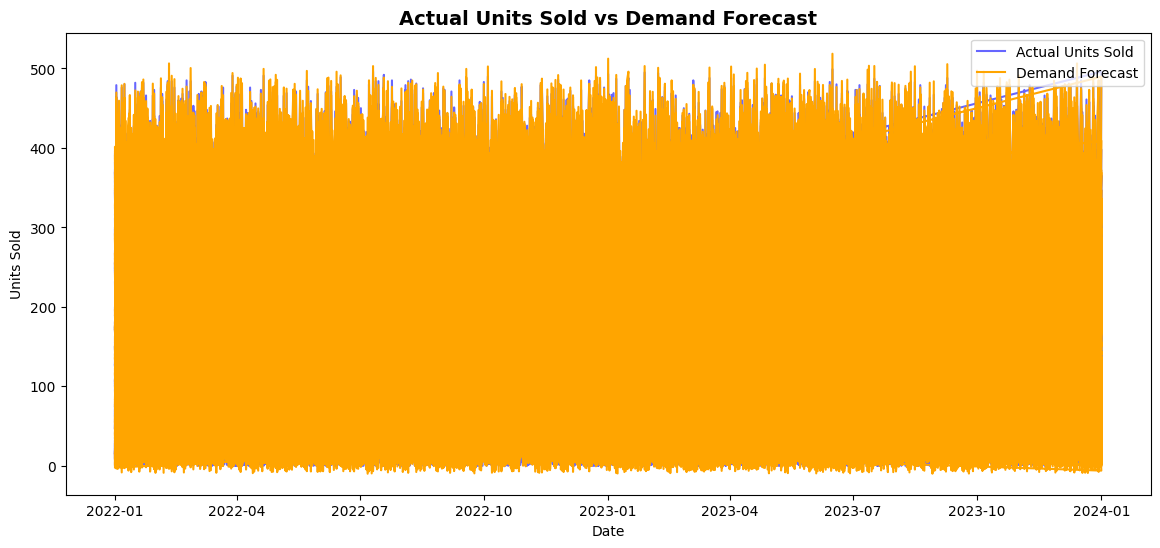

In [25]:
#Compare Demand Forecast column vs actual Units Sold
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Units Sold'], label='Actual Units Sold', color='blue', alpha=0.6)
plt.plot(data['Date'], data['Demand Forecast'], label='Demand Forecast', color='orange')
plt.title('Actual Units Sold vs Demand Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Date')  
plt.ylabel('Units Sold')
plt.legend()
plt.show()

## Feature Engineering and Data Preparation

### Create Time-Based Features
Extract useful information from dates (year, month, day, weekends, etc.)

In [26]:
# Extract date components that can help predict sales patterns
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_week'] = data['Date'].dt.dayofweek  # Monday=0, Sunday=6
data['day_of_year'] = data['Date'].dt.dayofyear
data['week_of_year'] = data['Date'].dt.isocalendar().week
data['quarter'] = data['Date'].dt.quarter

# Create helpful binary flags
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)  # Saturday/Sunday
data['is_month_start'] = data['Date'].dt.is_month_start.astype(int)
data['is_month_end'] = data['Date'].dt.is_month_end.astype(int)
data['is_year_start'] = data['Date'].dt.is_year_start.astype(int)
data['is_year_end'] = data['Date'].dt.is_year_end.astype(int)
data.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,...,day,day_of_week,day_of_year,week_of_year,quarter,is_weekend,is_month_start,is_month_end,is_year_start,is_year_end
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,...,1,5,1,52,1,1,1,0,1,0
100,2022-01-02,S001,P0001,Groceries,West,116,81,104,92.94,27.95,...,2,6,2,52,1,1,0,0,0,0
200,2022-01-03,S001,P0001,Electronics,West,154,5,189,5.36,62.70,...,3,0,3,1,1,0,0,0,0,0
300,2022-01-04,S001,P0001,Groceries,South,85,58,193,52.87,77.88,...,4,1,4,1,1,0,0,0,0,0
400,2022-01-05,S001,P0001,Groceries,South,238,147,37,150.27,28.46,...,5,2,5,1,1,0,0,0,0,0


In [27]:
data = data.sort_values(['SKU_Compound_ID', 'Date']).reset_index(drop=True)

In [28]:
# Drop the Store ID and Product ID
#data.drop(columns=['Store ID', 'Product ID'], inplace=True)
data.columns


Index(['Date', 'Store ID', 'Product ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality', 'SKU_Compound_ID', 'day_name',
       'month_name', 'year', 'month', 'day', 'day_of_week', 'day_of_year',
       'week_of_year', 'quarter', 'is_weekend', 'is_month_start',
       'is_month_end', 'is_year_start', 'is_year_end'],
      dtype='object')

### Create Price-Related Features
Calculate effective prices after discounts and compare with competitors.

In [29]:
# Calculate pricing metrics to understand price impact on sales
# Calculate the actual price customers pay after discount
data['effective_price'] = data['Price'] * (1 - data['Discount']/100) 

# How much cheaper/expensive are we compared to competitors?
data['price_vs_competitor'] = data['Price'] / data['Competitor Pricing']
data['competitor_price_diff'] = data['Price'] - data['Competitor Pricing']
data['competitor_price_pct_change'] = (data['Price'] - data['Competitor Pricing']) / data['Competitor Pricing'] * 100


# Price discount ratio (original price to discounted price ratio)
data['price_discount_ratio'] = data['Price'] / data['effective_price']


ENCODING

In [30]:
# Check the categorical columns in the dataset
cat_cols = data.select_dtypes(include=['object']).columns
print(f"Categorical columns found: {list(cat_cols)}")
data[cat_cols].head()

Categorical columns found: ['Store ID', 'Product ID', 'Category', 'Region', 'Weather Condition', 'Seasonality', 'SKU_Compound_ID', 'day_name', 'month_name']


,Store ID,Product ID,Category,Region,Weather Condition,Seasonality,SKU_Compound_ID,day_name,month_name
0,S001,P0001,Groceries,North,Rainy,Autumn,S001_P0001,Saturday,January
1,S001,P0001,Groceries,West,Cloudy,Spring,S001_P0001,Sunday,January
2,S001,P0001,Electronics,West,Rainy,Winter,S001_P0001,Monday,January
3,S001,P0001,Groceries,South,Cloudy,Winter,S001_P0001,Tuesday,January
4,S001,P0001,Groceries,South,Sunny,Winter,S001_P0001,Wednesday,January


In [31]:
# ONE HOT ENCODE CATEGORICAL COLUMNS
cat_cols = ['Category', 'Region', 'Weather Condition', 'Seasonality']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
data.head()

,Date,Store ID,Product ID,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,...,Category_Toys,Region_North,Region_South,Region_West,Weather Condition_Rainy,Weather Condition_Snowy,Weather Condition_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
0,2022-01-01,S001,P0001,231,127,55,135.47,33.50,20,0,...,False,True,False,False,True,False,False,False,False,False
1,2022-01-02,S001,P0001,116,81,104,92.94,27.95,10,0,...,False,False,False,True,False,False,False,True,False,False
2,2022-01-03,S001,P0001,154,5,189,5.36,62.70,20,0,...,False,False,False,True,True,False,False,False,False,True
3,2022-01-04,S001,P0001,85,58,193,52.87,77.88,15,1,...,False,False,True,False,False,False,False,False,False,True
4,2022-01-05,S001,P0001,238,147,37,150.27,28.46,20,1,...,False,False,True,False,False,False,True,False,False,True


In [32]:
# SKU/Store label encoding
data['sku_code'] = data['SKU_Compound_ID'].astype('category').cat.codes

In [33]:
# Groupby object to create lag/rolling feature per SKU_Compound_ID
g = data.groupby('SKU_Compound_ID', group_keys=False)

In [34]:
# Lag features for Units Sold (pure historical lags)
lag_days = [1, 7, 14, 28]
for lag in lag_days:
    data[f'units_sold_lag_{lag}'] = g['Units Sold'].shift(lag)

In [35]:
# Rolling features (use shift(1) to avoid peeking current day)
roll_windows = [7, 14, 28]
for w in roll_windows:
    data[f'units_sold_roll_mean_{w}'] = g['Units Sold'].apply(lambda x: x.shift(1).rolling(window=w, min_periods=1).mean())
    data[f'units_sold_roll_std_{w}']  = g['Units Sold'].apply(lambda x: x.shift(1).rolling(window=w, min_periods=1).std()).fillna(0)
    
# Rolling median (robust)
    data['units_sold_roll_median_14'] = g['Units Sold'].apply(lambda x: x.shift(1).rolling(window=14, min_periods=1).median())

In [36]:
# SKU-level aggregates (global historical stats)
data['sku_mean_demand'] = g['Units Sold'].transform('mean')
data['sku_std_demand']  = g['Units Sold'].transform('std').fillna(0)
data['sku_median_demand'] = g['Units Sold'].transform('median')

### Inventory related features

In [37]:
# inventory to expected demand ratio (use recent 7-day rolling mean as expected demand)
data['inventory_expecteddemand_ratio'] = data['Inventory Level'] / (data['units_sold_roll_mean_7'].replace(0, np.nan))
data['inventory_expecteddemand_ratio'] = data['inventory_expecteddemand_ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [38]:
# Stockout / understock signal
data['stockout_flag'] = (data['Inventory Level'] <= 0).astype(int)

# low_inventory_flag: inventory less than one period's expected demand (7-day mean)
data['low_inventory_flag'] = ((data['Inventory Level'] < data['units_sold_roll_mean_7'])).astype(int)

In [39]:
# Promotions: days since last promotion for each SKU 
if 'Holiday/Promotion' in data.columns:
    print("Creating days since promotion feature...")
    
    # Simple approach: calculate days since promotion using a loop approach
    data['days_since_promo'] = 999  # Default value for never promoted
    
    # Process each SKU separately
    for sku in data['SKU_Compound_ID'].unique():
        sku_mask = data['SKU_Compound_ID'] == sku
        sku_data = data.loc[sku_mask].copy()
        
        # Find promotion dates for this SKU
        promo_dates = sku_data[sku_data['Holiday/Promotion'] == 1]['Date'].values
        
        if len(promo_dates) > 0:
            # Calculate days since last promotion for each date
            for idx, row_date in sku_data['Date'].items():
                # Find the most recent promotion before this date
                past_promos = promo_dates[promo_dates <= row_date]
                if len(past_promos) > 0:
                    last_promo = past_promos.max()
                    days_since = (row_date - last_promo).days
                    data.loc[idx, 'days_since_promo'] = days_since
    
    print(f"✅ Days since promotion feature created successfully!")
    print(f"   Average days since last promotion: {data['days_since_promo'].mean():.1f}")
    print(f"   Max days since promotion: {data['days_since_promo'].max()}")
    print(f"   Min days since promotion: {data['days_since_promo'].min()}")
else:
    print("❌ Holiday/Promotion column not found in dataset")

Creating days since promotion feature...
✅ Days since promotion feature created successfully!
   Average days since last promotion: 2.6
   Max days since promotion: 999
   Min days since promotion: 0
✅ Days since promotion feature created successfully!
   Average days since last promotion: 2.6
   Max days since promotion: 999
   Min days since promotion: 0


In [40]:
# Recent demand trend: difference between last lag and lag_7 mean
data['demand_trend_1_7'] = data['units_sold_lag_1'] - data['units_sold_roll_mean_7']

#  DEMAND FORECASTING ENGINE

In [41]:
# Keras for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
#prepare time series data for modeling
ts_data = daily_demand.rename(columns={'Date': 'ds', 'Units Sold': 'y'})


In [43]:
# Train test split for time series 
train_size = int(len(ts_data) * 0.8)
train_data = ts_data.iloc[:train_size]
test_data = ts_data.iloc[train_size:]


### SARIMA

Determine Optimal Parameters using ACF/PACF plots

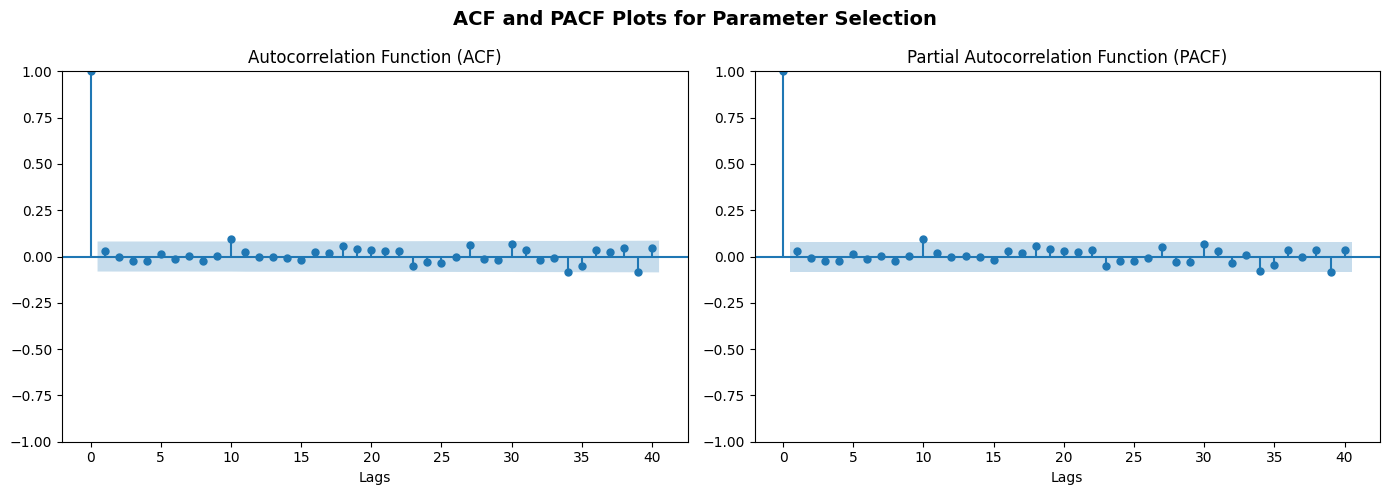

In [44]:
# ACF and PACF plots help determine optimal (p, d, q) parameters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('ACF and PACF Plots for Parameter Selection', fontsize=14, fontweight='bold')

# ACF plot helps determine MA order (q)
plot_acf(train_data['y'], lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lags')

# PACF plot helps determine AR order (p)
plot_pacf(train_data['y'], lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lags')

plt.tight_layout()
plt.show()



- The blue shaded region represents the 95% confidence interval.
- ACF: Identifies the MA (Moving Average) order q = 1 or 2
- PACF: dentifies the AR (AutoRegressive) order p = 1
- Spikes outside blue region are significant
- he plots don't show strong weekly (lag 7) patterns, but since this is daily retail data, keeping seasonal_order=(1,1,1,7) makes business sense

**💡 Why Two Approaches? ACF/PACF vs Auto ARIMA**

**Option 1: Manual Approach (ACF/PACF)**
- You CAN use the parameters from ACF/PACF plots directly in SARIMA
- ACF/PACF gives you a **visual interpretation** to choose p, d, q
- Requires **expertise** to read the plots correctly
- Good for **learning** and understanding the data patterns
- May need **trial and error** to find the best combination

**Option 2: Auto ARIMA (Automated)**
- **Systematically tests** hundreds of parameter combinations
- Uses **statistical criteria** (AIC, BIC) to pick the best model
- **Faster and more accurate** than manual tuning
- Great for **production systems** and when you need optimal results
- Removes human bias and guesswork

**Why Do Both?**
1. **Learning**: ACF/PACF helps you understand your data's behavior
2. **Validation**: Compare manual intuition with automated optimization
3. **Best Practice**: See if your visual interpretation matches the optimal solution
4. **Flexibility**: Sometimes domain knowledge (from ACF/PACF) beats pure statistics

**In Practice:** Most data scientists start with ACF/PACF for understanding, then use Auto ARIMA for the final production model.

Automatic Parameter Selection (Auto Arima)

In [45]:
# Auto ARIMA automatically finds the best (p,d,q) and (P,D,Q,m) parameters
print("Auto ARIMA tests multiple parameter combinations to find the best model.\n")

auto_model = auto_arima(
    train_data['y'],
    seasonal=True,           # Enable seasonal component
    m=7,                     # Weekly seasonality
    max_p=3,                 # Max AR order
    max_q=3,                 # Max MA order
    max_P=2,                 # Max seasonal AR order
    max_Q=2,                 # Max seasonal MA order
    max_d=2,                 # Max differencing
    max_D=1,                 # Max seasonal differencing
    trace=True,              # Print progress
    error_action='ignore',   # Ignore errors
    suppress_warnings=True,
    stepwise=True            # Use stepwise algorithm (faster)
)

print("Best Model Found:")
print(auto_model.summary())

Auto ARIMA tests multiple parameter combinations to find the best model.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=10110.135, Time=3.10 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=9759.917, Time=0.03 sec
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=10110.135, Time=3.10 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=9759.917, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=9763.444, Time=0.95 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=9763.442, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=12784.651, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=9763.444, Time=0.95 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=9763.442, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=12784.651, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=9761.917, Time=0.29 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=9761.908, Time=0.14 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=9761.917, Time=0.29 sec
 ARIMA(0,0,0)(0,0,1)[

The lowest AIC is better which gives us a seasonal_order = (0,0,0,7)
- Demand is relatively consistent day-to-day
- Weekly seasonality (period=7) isn't strong enough to require seasonal terms

In [46]:
# Generate predictions with Auto ARIMA model
auto_forecast = auto_model.predict(n_periods=len(test_data))

# Calculate metrics for Auto ARIMA
mae_auto = mean_absolute_error(test_data['y'], auto_forecast)
rmse_auto = np.sqrt(mean_squared_error(test_data['y'], auto_forecast))

print(f"Auto ARIMA Model Performance:")
print(f"MAE:  {mae_auto:.2f}")
print(f"RMSE: {rmse_auto:.2f}")

Auto ARIMA Model Performance:
MAE:  842.77
RMSE: 1051.14


Build Manual SARIMA model

In [47]:
# SARIMA modeling with weekly seasonality (period=7)
model = SARIMAX(train_data['y'], order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_result = model.fit(disp=False)
print(sarima_result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4858.393
Date:                           Wed, 26 Nov 2025   AIC                           9726.786
Time:                                   10:42:11   BIC                           9748.567
Sample:                                        0   HQIC                          9735.280
                                           - 584                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0401      0.039      1.035      0.301      -0.036       0.116
ma.L1         -0.9773      0.015    -67.094

INSIGHTS
- Lower AIC than Auto ARIMA's hence the model fits better and  captures more patterns in the data

In [48]:
# Generate forecasts for the test period
sarima_forecast = sarima_result.forecast(steps=len(test_data))
sarima_forecast

584    14040.028222
585    13900.355539
586    13972.252491
587    13980.959894
588    13691.434206
           ...     
726    14110.327704
727    14062.210954
728    13863.318653
729    14088.633548
730    13968.027094
Name: predicted_mean, Length: 147, dtype: float64

- The predictions range from approximately 13,691 to 14,110 units, showing relatively stable forecasts with small variations.

In [49]:
# Calculate evaluation metrics
mae_sarima = mean_absolute_error(test_data['y'], sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test_data['y'], sarima_forecast))

print(f"SARIMA Model Performance:")
print(f"MAE:  {mae_sarima:.2f}")
print(f"RMSE: {rmse_sarima:.2f}")

SARIMA Model Performance:
MAE:  907.14
RMSE: 1119.71


Higher RMSE due to penalizing larger errors, SARIMA performs slightly worse on the test set than Auto ARIMA.

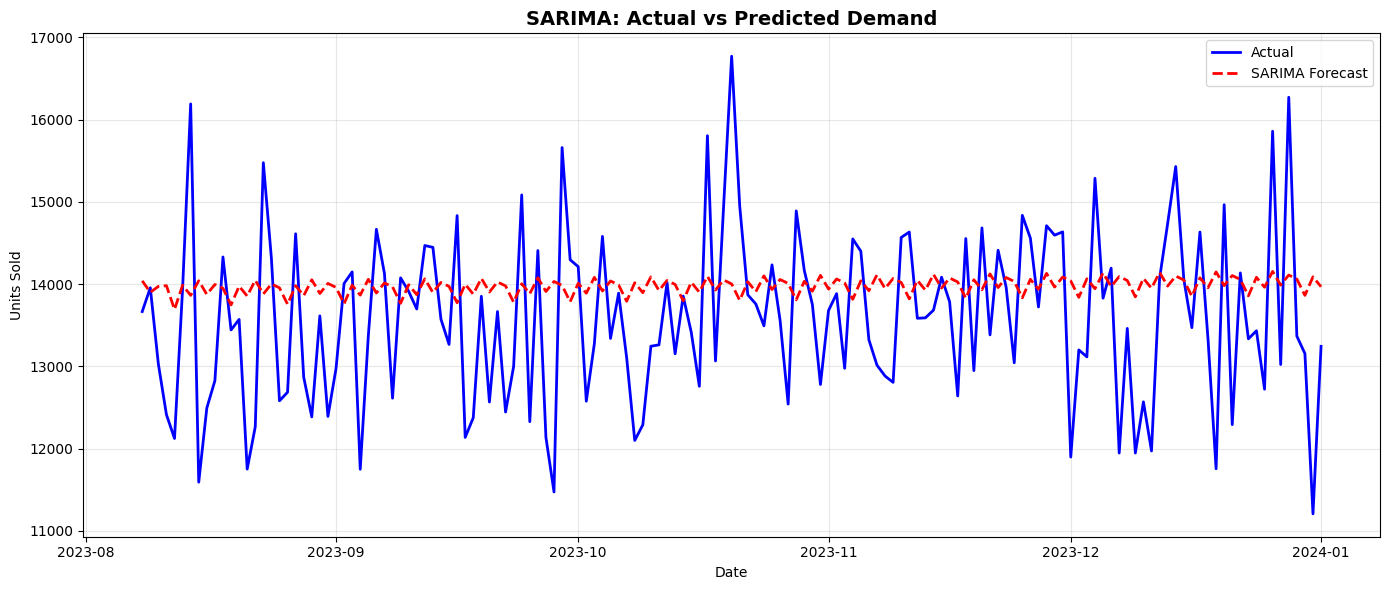

In [50]:
# Visualize SARIMA predictions vs actual values
plt.figure(figsize=(14, 6))
plt.plot(test_data['ds'], test_data['y'], label='Actual', color='blue', linewidth=2)
plt.plot(test_data['ds'], sarima_forecast, label='SARIMA Forecast', color='red', linewidth=2, linestyle='--')
plt.title('SARIMA: Actual vs Predicted Demand', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

INSIGHTS 
- SARIMA struggles to capture the large day-to-day fluctuations in demand, hence the gap.
- The model predicts a stable average while actual demand swings wildly.
- SARIMA works best with stable trends and clear seasonality, but the retail demand is quite erratic—likely driven by external factors (promotions, competitive pricing, weather) that SARIMA can't model.

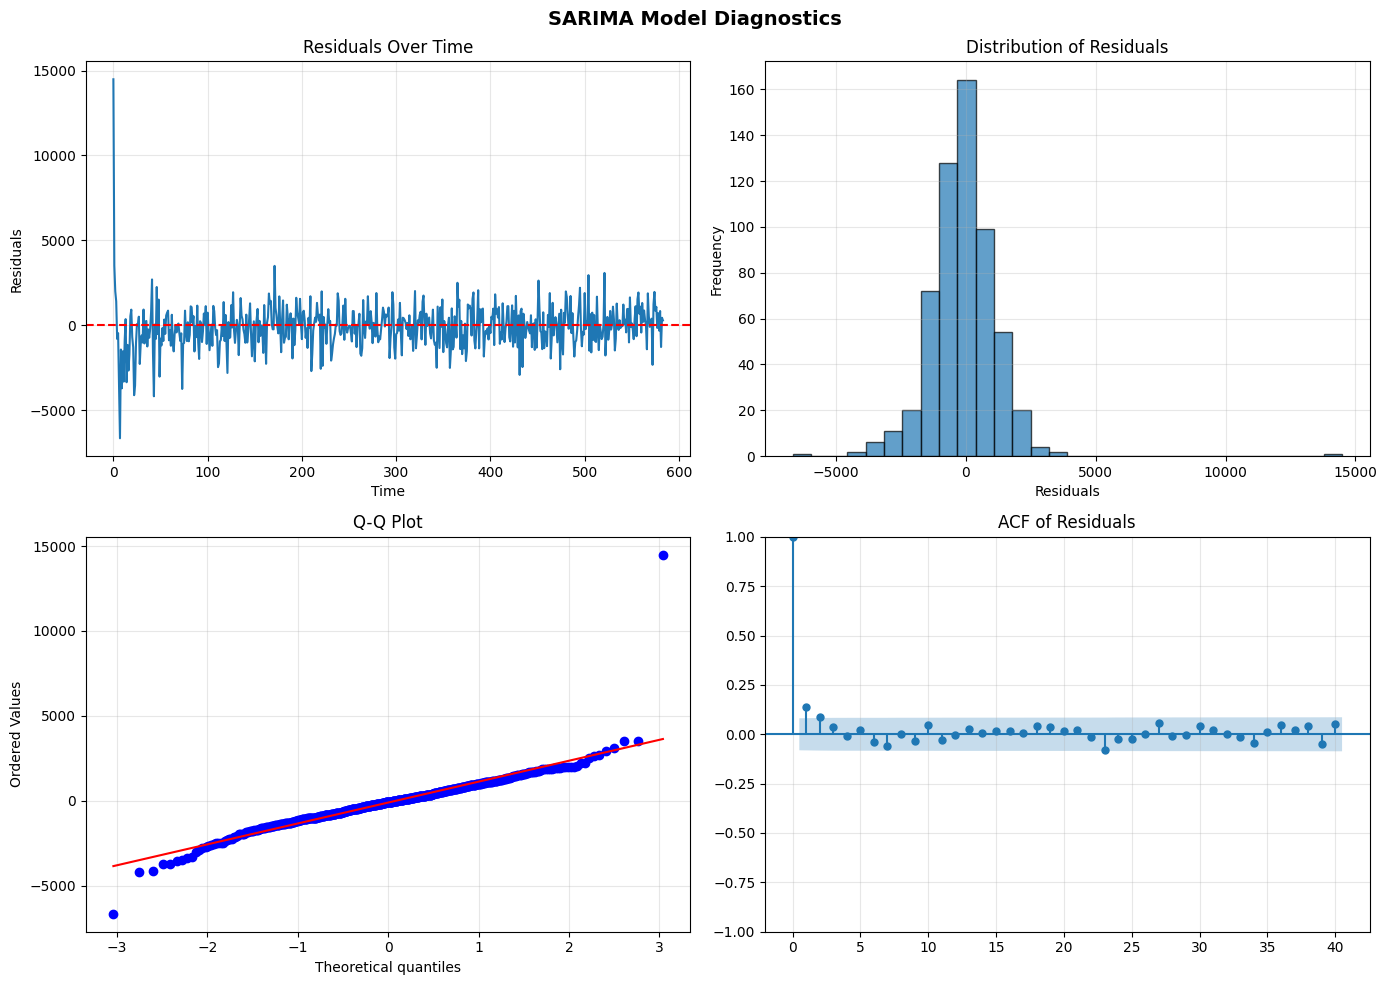


Residual Statistics:
Mean: -109.6038 (should be close to 0)
Std:  1320.0526


In [51]:
# Check model residuals (errors) to validate assumptions
residuals = sarima_result.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('SARIMA Model Diagnostics', fontsize=14, fontweight='bold')

# 1. Residuals over time
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histogram of residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q plot (check if residuals are normally distributed)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. ACF of residuals (check for autocorrelation)
plot_acf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('ACF of Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual Statistics:")
print(f"Mean: {residuals.mean():.4f} (should be close to 0)")
print(f"Std:  {residuals.std():.4f}")

- Residuals fluctuate around zero with constant variance.
- Normal distribution, good for model assumptions.
- Q - Q Plot ; residuals are mostly normal but with some outliers
- ACF of residuals ; minimal autocorrelation remaining - the model captured most patterns
- The High standard deviation reflects high volatility in demand. This confirms that SARIMA struggles.

Forecast with Confidence Intervals

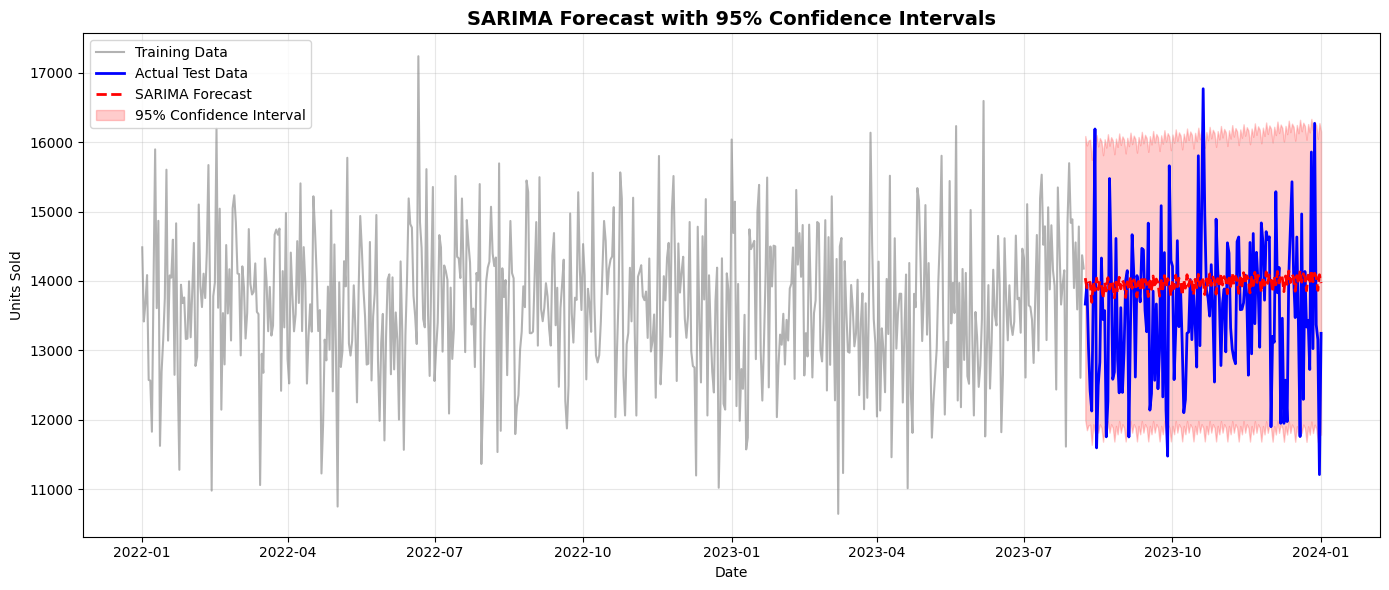

In [52]:
# Generate forecast with confidence intervals
forecast_results = sarima_result.get_forecast(steps=len(test_data))
forecast_mean = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

# Visualize with confidence intervals
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(train_data['ds'], train_data['y'], label='Training Data', color='gray', alpha=0.6)

# Plot actual test data
plt.plot(test_data['ds'], test_data['y'], label='Actual Test Data', color='blue', linewidth=2)

# Plot forecast
plt.plot(test_data['ds'], forecast_mean, label='SARIMA Forecast', color='red', linewidth=2, linestyle='--')

# Plot confidence intervals (shaded area)
plt.fill_between(
    test_data['ds'],
    confidence_intervals.iloc[:, 0],
    confidence_intervals.iloc[:, 1],
    color='red',
    alpha=0.2,
    label='95% Confidence Interval'
)

plt.title('SARIMA Forecast with 95% Confidence Intervals', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


- Many actual values fall outside the confidence band, indicating the model underestimates volatility
- The widening interval over time shows increasing forecast uncertainty.
- The wide confidence interval will tell us to maintain higher Safety Stock to handle the uncertainity.
- The upper bound (~16,200 units) could guide your maximum inventory levels to avoid stockouts during demand spikes

MODEL COMPARISON
          Model        MAE        RMSE
SARIMA (Manual) 907.144175 1119.713489
     Auto ARIMA 842.774124 1051.137769


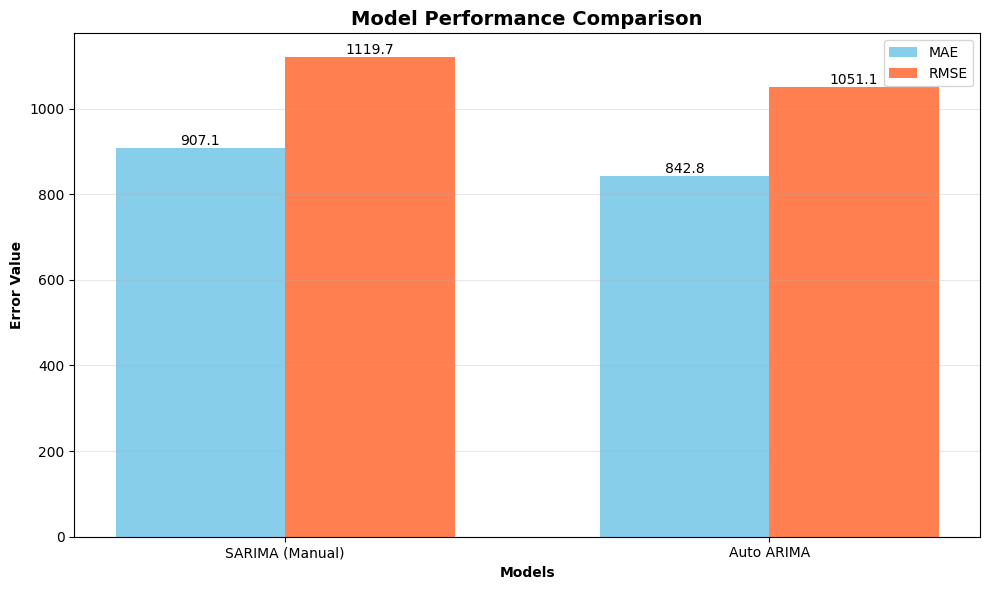

In [53]:
# Compare all models side by side
comparison_df = pd.DataFrame({
    'Model': ['SARIMA (Manual)', 'Auto ARIMA'],
    'MAE': [mae_sarima, mae_auto],
    'RMSE': [rmse_sarima, rmse_auto]
})


print("MODEL COMPARISON")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['MAE'], width, label='MAE', color='skyblue')
bars2 = ax.bar(x + width/2, comparison_df['RMSE'], width, label='RMSE', color='coral')

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Error Value', fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### PROPHET

In [54]:
# Aggregate data to daily level with relevant features for Prophet
daily_level = data.groupby('Date').agg({
    'Units Sold': 'sum',
    'Price': 'mean',                 # or use SKU-specific Price
    'Competitor Pricing': 'mean',
    'Holiday/Promotion': 'max'       # daily flag if any SKU had promo
}).reset_index().rename(columns={'Date':'ds','Units Sold':'y'})

# Create a simple lag/rolling regressor that is computable at forecast time
daily_level = daily_level.sort_values('ds')
daily_level['roll_mean_7'] = daily_level['y'].shift(1).rolling(7, min_periods=1).mean()
daily_level['lag_7'] = daily_level['y'].shift(7)

# Drop early rows with NaNs introduced by shifts
daily_level = daily_level.dropna().reset_index(drop=True)

In [55]:
# Prophet modelling
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, changepoint_prior_scale=0.05)
prophet_model.fit(daily_level[['ds', 'y']])


10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:15 - cmdstanpy - INFO - Chain [1] done processing
10:42:15 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
from prophet.diagnostics import cross_validation, performance_metrics

In [57]:
# Rolling-origin cross-validation for Prophet model
# Adjusted parameters to fit the 584-day training dataset
cv_base_results = cross_validation(prophet_model, initial='366 days', period='90 days', horizon='30 days', parallel="processes")

# Calculate performance metrics
cv_performance = performance_metrics(cv_base_results).loc[:, ['horizon', 'mae', 'rmse', 'mape']].groupby('horizon').mean()
print("Baseline Prophet Model Cross-Validation Performance:\n", cv_performance)


Baseline Prophet Model Cross-Validation Performance:
                  mae         rmse      mape
horizon                                    
3 days   1306.216394  1610.327461  0.098204
4 days    883.509897  1056.373045  0.066483
5 days    877.933091  1025.358628  0.068279
6 days    773.332145   954.090747  0.061325
7 days    709.822917   844.677098  0.055349
8 days    470.594433   595.866064  0.036153
9 days    573.785327   701.942225  0.044448
10 days   552.208722   657.310675  0.040973
11 days   591.810936   747.203161  0.042676
12 days   752.897524  1019.277383  0.053995
13 days   903.431728  1139.582108  0.065366
14 days  1074.034575  1211.454822  0.080015
15 days   924.908686  1035.968836  0.068872
16 days   697.322306   847.661216  0.052823
17 days   693.531633   873.405451  0.053949
18 days   710.870459   918.760987  0.054235
19 days   896.659603  1056.302181  0.069875
20 days   737.221759   912.667184  0.055186
21 days   919.678764  1103.642311  0.066085
22 days   804.376257  

## Prophet with External Regressors

**What are External Regressors?**
External regressors (also called additional regressors) are extra variables that might influence your target variable (demand). Prophet allows you to add these factors to improve forecasting accuracy.

**How it works:**
- Prophet's base model captures trends and seasonality automatically
- External regressors add the impact of business factors (price, promotions, weather, etc.)
- The model learns how much each factor affects demand
- Formula: `demand = trend + seasonality + regressor_effects + error`

**Benefits:**
- More accurate forecasts when external factors matter
- Understand which business levers drive demand
- Better predictions during promotions or price changes

In [58]:
# Pick regressors you want to test
regressors = ['Price','Competitor Pricing','Holiday/Promotion','roll_mean_7']

m_reg = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    changepoint_prior_scale=0.05
)

# Register regressors with Prophet (standardize=True/False as needed)
for r in regressors:
    # For binary regressors you can set standardize=False
    m_reg.add_regressor(r, standardize=True)

# Fit model; ensure daily contains these columns
train_cols = ['ds','y'] + regressors
m_reg.fit(daily_level[train_cols])

# Cross-validate
df_cv_reg = cross_validation(m_reg, initial='366 days', period='90 days', horizon='30 days', parallel="processes")
perf_reg = performance_metrics(df_cv_reg).loc[:, ['horizon','mae','rmse','mape']].groupby('horizon').mean()
print("Regressor model performance:\n", perf_reg)

10:42:27 - cmdstanpy - INFO - Chain [1] start processing
10:42:27 - cmdstanpy - INFO - Chain [1] done processing
10:42:27 - cmdstanpy - INFO - Chain [1] done processing


Regressor model performance:
                  mae         rmse      mape
horizon                                    
3 days   1275.720465  1597.451383  0.096710
4 days    840.366165  1010.488599  0.063565
5 days    814.796034   998.191997  0.064014
6 days    742.467757   956.398140  0.059303
7 days    687.778306   844.168018  0.053965
8 days    505.721816   656.405652  0.039031
9 days    646.496013   789.670498  0.050204
10 days   587.278295   711.828799  0.043942
11 days   598.640974   728.498005  0.043564
12 days   706.929370   944.861757  0.051057
13 days   880.515526  1096.983844  0.064060
14 days  1042.139824  1178.562271  0.077874
15 days   960.636812  1071.079081  0.071330
16 days   775.642295   904.789064  0.058480
17 days   774.851836   931.153890  0.059454
18 days   780.162075  1024.552283  0.058863
19 days   937.317308  1158.984473  0.072289
20 days   840.376082  1079.367553  0.062570
21 days   928.254638  1062.241722  0.067449
22 days   839.149748   957.142710  0.059158
23

Ablation Testing(Baseline vs Single regressors vs groups)

This loop runs Prophet baseline and then tests each regressor individually and all together. It records MAE

In [59]:
from collections import defaultdict

def run_prophet_with_regressors(df, regressors_list, initial='366 days', period='90 days', horizon='30 days'):
    results = {}
    # baseline
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.05)
    m.fit(df[['ds','y']])
    cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel="processes")
    perf = performance_metrics(cv)
    results['baseline'] = perf[['mae', 'rmse']].mean()

    # single regressor tests
    for reg in regressors_list:
        m = Prophet(yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.05)
        m.add_regressor(reg)
        m.fit(df[['ds','y', reg]])
        cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel="processes")
        perf = performance_metrics(cv)
        results[f'only_{reg}'] = perf[['mae', 'rmse']].mean()

    # combined
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, changepoint_prior_scale=0.05)
    for reg in regressors_list:
        m.add_regressor(reg)
    m.fit(df[['ds','y'] + regressors_list])
    cv = cross_validation(m, initial=initial, period=period, horizon=horizon, parallel="processes")
    perf = performance_metrics(cv)
    results['all_regressors'] = perf[['mae', 'rmse']].mean()

    return results

regressors_to_test = ['Price','Competitor Pricing','Holiday/Promotion','roll_mean_7']
ablation_results = run_prophet_with_regressors(daily_level, regressors_to_test)
print(ablation_results)

10:42:36 - cmdstanpy - INFO - Chain [1] start processing
10:42:36 - cmdstanpy - INFO - Chain [1] done processing
10:42:36 - cmdstanpy - INFO - Chain [1] done processing
10:42:45 - cmdstanpy - INFO - Chain [1] start processing
10:42:45 - cmdstanpy - INFO - Chain [1] start processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:46 - cmdstanpy - INFO - Chain [1] done processing
10:42:55 - cmdstanpy - INFO - Chain [1] start processing
10:42:55 - cmdstanpy - INFO - Chain [1] start processing
10:42:55 - cmdstanpy - INFO - Chain [1] done processing
10:42:55 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] done processing
10:43:20 - cmdstanpy - INFO - Chain [1] start processing
10:43:20 - cmdstanpy - INFO - Chain [1] done processing
10:43:28 - cmdstanpy - INFO - Chain [1] 

{'baseline': mae      845.489467
rmse    1041.385156
dtype: float64, 'only_Price': mae      847.121197
rmse    1043.061322
dtype: float64, 'only_Competitor Pricing': mae      847.273307
rmse    1042.873067
dtype: float64, 'only_Holiday/Promotion': mae      845.445124
rmse    1041.299720
dtype: float64, 'only_roll_mean_7': mae      859.478504
rmse    1050.304503
dtype: float64, 'all_regressors': mae      867.024717
rmse    1059.774917
dtype: float64}


Interpreting ablation results

- Adding a regressor Increases MAE (or MAPE/RMSE) relative to baseline, the regressor is likely noisy / not predictive.
- The combined regressors perform worse than best single regressor, you may be overfitting or the regressors adding  noise — remove or regularize.

In [60]:
# # Forecasting 
# horizon = 30
# future = m_reg.make_future_dataframe(periods=horizon, freq='D')

# # create a small DataFrame of regressor values indexed by ds (from the historical daily)
# reg_df = daily_level[['ds'] + regressors].set_index('ds')
# # merge last known regressor values (simple approach)
# future = future.merge(reg_df.reset_index(), on='ds', how='left')

# # Fill missing future regressor values with last observed
# for r in regressors:
#     future[r] = future[r].ffill().bfill().fillna(daily_level[r].iloc[-1])

# forecast = m_reg.predict(future)
# # forecast contains yhat, yhat_lower, yhat_upper

### Detailed Comparison: Prophet Baseline vs Prophet with Regressors

Since ablation testing showed that adding regressors **worsens** performance, let's formally compare both approaches and visualize the results.

In [61]:
# Extract MAE and RMSE from ablation results for comparison
baseline_mae = ablation_results['baseline']['mae']
baseline_rmse = ablation_results['baseline']['rmse']

regressors_mae = ablation_results['all_regressors']['mae']
regressors_rmse = ablation_results['all_regressors']['rmse']

print("PROPHET MODEL COMPARISON")
print(f"\n{'Model':<30} {'MAE':<12} {'RMSE':<12}")
print(f"{'Prophet Baseline':<30} {baseline_mae:>10.2f}   {baseline_rmse:>10.2f}")
print(f"{'Prophet with Regressors':<30} {regressors_mae:>10.2f}   {regressors_rmse:>10.2f}")


# Calculate improvement/degradation
mae_change = ((regressors_mae - baseline_mae) / baseline_mae) * 100
rmse_change = ((regressors_rmse - baseline_rmse) / baseline_rmse) * 100

print(f"\n Performance Change with Regressors:")
print(f"   MAE:  {mae_change:+.2f}% ({'worse' if mae_change > 0 else 'better'})")
print(f"   RMSE: {rmse_change:+.2f}% ({'worse' if rmse_change > 0 else 'better'})")

if mae_change > 0 and rmse_change > 0:
    print("\n CONCLUSION: Prophet Baseline performs better. Use the baseline model.")
else:
    print("\n CONCLUSION: Regressors help. Use the model with regressors.")

PROPHET MODEL COMPARISON

Model                          MAE          RMSE        
Prophet Baseline                   845.49      1041.39
Prophet with Regressors            867.02      1059.77

 Performance Change with Regressors:
   MAE:  +2.55% (worse)
   RMSE: +1.77% (worse)

 CONCLUSION: Prophet Baseline performs better. Use the baseline model.


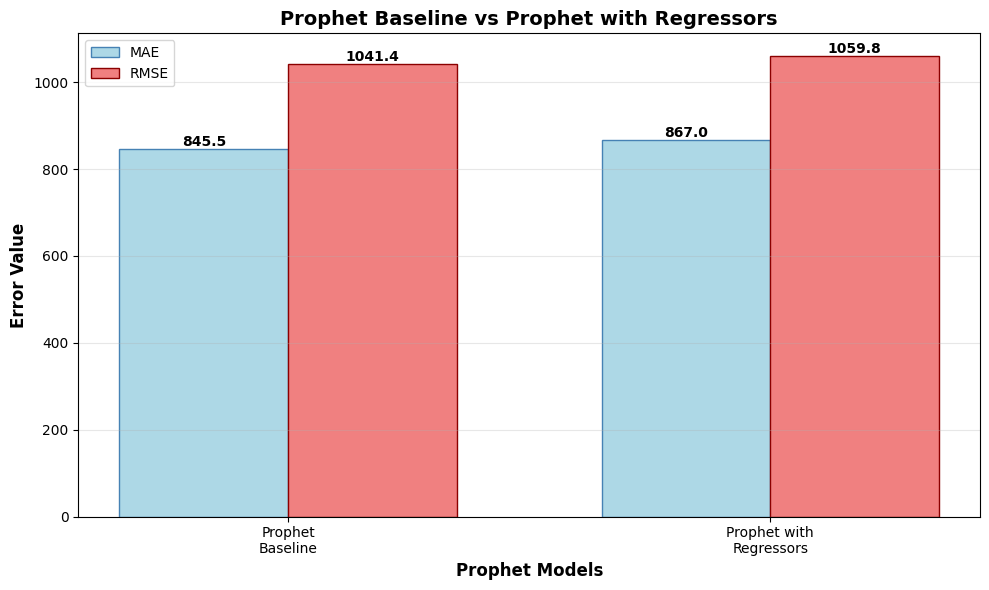

In [62]:
# Visualize the comparison
fig, ax = plt.subplots(figsize=(10, 6))
models = ['Prophet\nBaseline', 'Prophet with\nRegressors']
x = np.arange(len(models))
width = 0.35

mae_values = [baseline_mae, regressors_mae]
rmse_values = [baseline_rmse, regressors_rmse]

bars1 = ax.bar(x - width/2, mae_values, width, label='MAE', color='lightblue', edgecolor='steelblue')
bars2 = ax.bar(x + width/2, rmse_values, width, label='RMSE', color='lightcoral', edgecolor='darkred')

ax.set_xlabel('Prophet Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Error Value', fontweight='bold', fontsize=12)
ax.set_title('Prophet Baseline vs Prophet with Regressors', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Complete Model Comparison: SARIMA vs Prophet

Now let's compare ALL forecasting models to select the best one for production.

In [66]:
# Create comprehensive comparison table
all_models_comparison = pd.DataFrame({
    'Model': [
        'Auto ARIMA',
        'SARIMA (Manual)',
        'Prophet Baseline',
        'Prophet with Regressors'
    ],
    'MAE': [
        mae_auto,
        mae_sarima,
        baseline_mae,
        regressors_mae
    ],
    'RMSE': [
        rmse_auto,
        rmse_sarima,
        baseline_rmse,
        regressors_rmse
    ]
})

# Sort by RMSE (best first)
all_models_comparison = all_models_comparison.sort_values('RMSE').reset_index(drop=True)

print("=" * 70)
print("COMPREHENSIVE MODEL COMPARISON - ALL FORECASTING METHODS")
print("=" * 70)
print(all_models_comparison.to_string(index=False))
print("=" * 70)
print("\n Lower RMSE = Better Model")
print(f"\n BEST MODEL: {all_models_comparison.iloc[0]['Model']}")
print(f"   MAE:  {all_models_comparison.iloc[0]['MAE']:.2f}")
print(f"   RMSE: {all_models_comparison.iloc[0]['RMSE']:.2f}")

COMPREHENSIVE MODEL COMPARISON - ALL FORECASTING METHODS
                  Model        MAE        RMSE
       Prophet Baseline 845.489467 1041.385156
             Auto ARIMA 842.774124 1051.137769
Prophet with Regressors 867.024717 1059.774917
        SARIMA (Manual) 907.144175 1119.713489

 Lower RMSE = Better Model

 BEST MODEL: Prophet Baseline
   MAE:  845.49
   RMSE: 1041.39


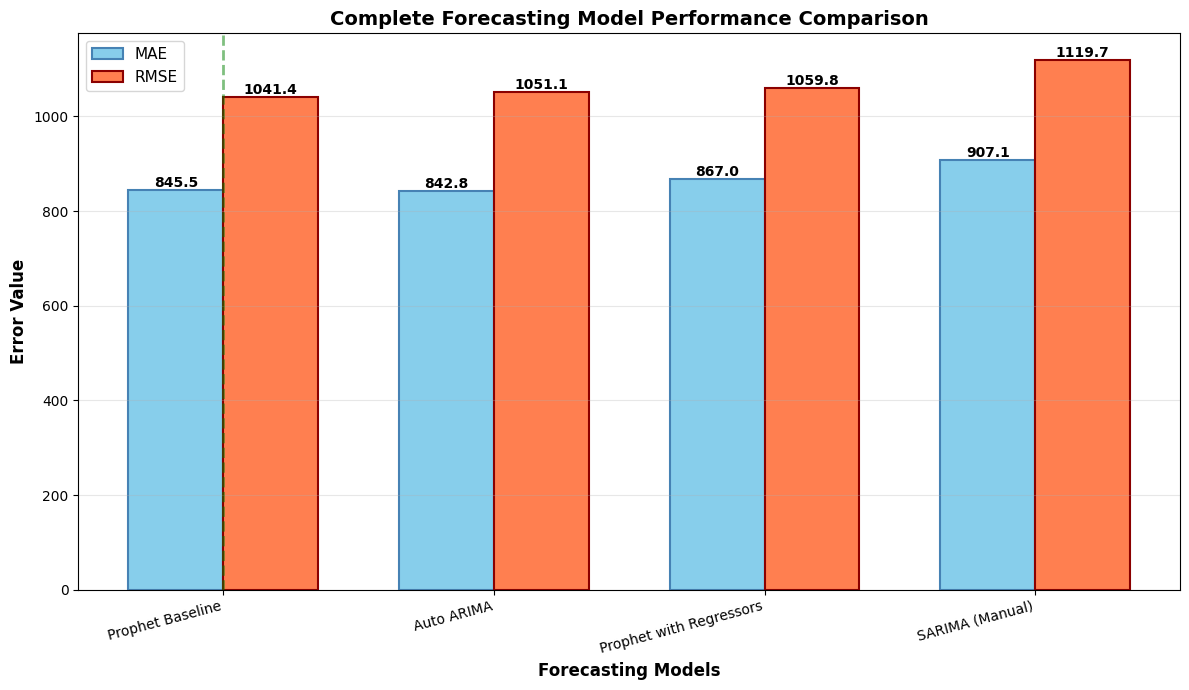

In [67]:
# Visualize complete comparison
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(all_models_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, all_models_comparison['MAE'], width, 
               label='MAE', color='skyblue', edgecolor='steelblue', linewidth=1.5)
bars2 = ax.bar(x + width/2, all_models_comparison['RMSE'], width, 
               label='RMSE', color='coral', edgecolor='darkred', linewidth=1.5)

ax.set_xlabel('Forecasting Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Error Value', fontweight='bold', fontsize=12)
ax.set_title('Complete Forecasting Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(all_models_comparison['Model'], rotation=15, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Highlight the best model
best_idx = 0
ax.axvline(x=best_idx, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Best Model')

plt.tight_layout()
plt.show()

### Model chosen is Prophet

Based on the comprehensive comparison above, we can now make a data-driven decision to use Prophet model for production forecasting.
Because:
   - Prophet generalizes better to unseen data
   - External regressors added noise rather than signal
   - Prophet captures trend and seasonality automatically
   - Less prone to overfitting

### Benchmark with LSTM(Long Short Term Memory Neural Networks)